In [1]:
import pandas as pd
import email
import os
import quopri
import re
# Define the path to the email file
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
import csv
import chardet
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


In [2]:
#class pour recuperer les informations d'un email
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mekki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mekki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Mekki\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Projet classification des e-mails
Lors de ce projet nous allons entrainer un modele qui servira de classificateur a e-mail pour faire nous allons procedes par plusieur etapes qui seront

- Préprocessing (Prétraitement) qui servira a modéliser nos information de tel sorte qu'elles soient plus clair et simple a classer pour notre modele et cela sans changer leur signification

# Lecture des e mails

In [7]:

class EmailParser:
    def __init__(self, email_file):
        self.file = email_file
        with open(email_file, 'rb') as f:
            result = chardet.detect(f.read())
            encoding = result['encoding']
        try:
            with open(email_file,"r",encoding=encoding) as f:
                self.msg = email.message_from_file(f)
                self.parse()
        except Exception as e:
            try:
                with open(email_file,"r",encoding="latin-1") as f:
                    self.msg = email.message_from_file(f)
                    self.parse()
            except Exception as e:
                with open(email_file,"r",encoding="utf-8") as f:
                    self.msg = email.message_from_file(f)
                    self.parse() 
            
    def parse(self):
        def decode_header(encoded_header):
            decoded_header = ""
            for (value, charset) in email.header.decode_header(encoded_header):
                if charset is None:
                    try:
                        decoded_header += value
                    except Exception as e:
                        decoded_header += value.decode()
                    
                else:
                    decoded_header += quopri.decodestring(value).decode(charset)
            return decoded_header
        
        def notoyage(text):
            soup = BeautifulSoup( text, "html.parser") #get text from body (HTML/text)
            text = soup.get_text().lower() # pour  tout mettre en minuscule et enlever les balises html
            text = re.sub(r"https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+/\S*\??(?:[-\w.&%=]+)?", 'httpaddr', text, flags=re.MULTILINE) #remove links
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', text, flags=re.MULTILINE) #remove email addresses
            text = re.sub(r"\$", "dollar", text, flags=re.MULTILINE)# remove $ sign
            text = re.sub(r'[^\w\s]', ' ', text) #remove non alphanumeric characters
            text = re.sub(r"\d+", 'nombre', text, flags=re.MULTILINE)#remove digits
            text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
            text = re.sub(r'\s+', ' ', text) #remove extra spaces
            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words] # remove stop words
            words_list = [lemmatizer.lemmatize(w) for w in words_list] #lemmatization
            words_list = [stemmer.stem(w) for w in words_list] #Stemming
            return " ".join(words_list)
        # Parse the email using the email library
        # Extract the email elements
        try:
            self.sender = decode_header(self.msg.get("From"))
        except Exception as e:
            self.sender = ''
        try:
            self.subject = decode_header(self.msg.get("Subject"))
        except Exception as e:
            self.subject = ''

        try:
            self.date = decode_header(self.msg.get("Date"))
        except Exception as e:
            self.date = ''
        
        try:
            self.to = decode_header(self.msg.get("To"))
        except Exception as e:
            self.to = ''
        
        self.body = ""

        # Extract the body of the email, which may be multipart
        if self.msg.is_multipart():
            for part in self.msg.walk():
                content_type = part.get_content_type()
                content_disposition = str(part.get("Content-Disposition"))
                if content_type == "text/plain" and "attachment" not in content_disposition:
                    self.body = part.get_payload(decode=True)
                    charset = self.msg.get_charset()
                    if not charset:
                        charset = 'iso-8859-1'
                    self.body = self.body.decode(charset)
        else:
            content_type = self.msg.get_content_type()
            if content_type == "text/plain":
                self.body = self.msg.get_payload(decode=True)
                charset = self.msg.get_charset()
                if not charset:
                    charset = 'iso-8859-1'
                self.body = self.body.decode(charset)
        self.body = re.sub(r'(URL:.*\s)', '', self.body, flags=re.MULTILINE)
        self.body = re.sub(r'Date:.*\n', '', self.body, flags=re.MULTILINE)
        
        self.body = notoyage(self.body)
        self.subject = notoyage(self.subject)
        

easy_normal = os.listdir('easy_ham')
hard_normal = os.listdir('hard_ham')
spam = os.listdir('spam_2')

header = ['From', 'To', 'Subject', 'Date', 'Body', 'Label']

with open('Emails.csv', 'w', encoding='UTF8') as f:
    # write the header
    writer = csv.writer(f,lineterminator = '\n')
    writer.writerow(header)
    for email_file in spam:
        email_file = os.path.join('spam_2', email_file)
        parsed = EmailParser(email_file)
        data = [parsed.sender, parsed.to, parsed.subject, parsed.date, parsed.body, 'spam']
        writer.writerow(data)

    for email_file in easy_normal:
        email_file = os.path.join('easy_ham', email_file)
        parsed = EmailParser(email_file)
        data = [parsed.sender, parsed.to, parsed.subject, parsed.date, parsed.body, 'ham']
        # write the data
        writer.writerow(data)
    for email_file in hard_normal:
        email_file = os.path.join('hard_ham', email_file)
        parsed = EmailParser(email_file)
        data = [parsed.sender, parsed.to, parsed.subject, parsed.date, parsed.body, 'ham']
        # write the data
        writer.writerow(data)



d:\APPS\python\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.efi.ie" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
d:\APPS\python\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://iiu.taint.org" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
d:\APPS\python\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.rebackee.com/cursos2/contraloria.htm
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
d:\APPS\python\lib\site-packages\bs4\__

# Creation du vocabulaire

In [8]:
Corpus = pd.read_csv(r"Emails.csv",encoding='UTF8')
nbElements = Corpus.shape[0]
Corpus = Corpus.dropna(subset=['Body'])
print(Corpus.shape[0])
#on vas prendre les mots qui apparaissent au moins 3 fois et on prend les 3000 mots les plus fréquents
Tfidf_vect = TfidfVectorizer(max_features=3000,min_df=10)

Tfidf_vect.fit(Corpus['Body'])
Tfidf_vect.vocabulary_

Vocabulaire = np.array(Tfidf_vect.get_feature_names())
Vocabulaire = np.array(Vocabulaire)

np.savetxt("Vocabulaire.csv", Vocabulaire, delimiter=",",encoding='UTF8',fmt='%s')

3426


d:\APPS\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Creation vecteur de caracteristique

In [9]:
Dataset = np.zeros((nbElements,len(Vocabulaire)))
Corpus = pd.read_csv(r"Emails.csv",encoding='UTF8')
for i in range(nbElements):
    for j in range(len(Vocabulaire)):
        if Vocabulaire[j] in str(Corpus['Body'][i]):
            Dataset[i,j] +=1
Dataset = np.column_stack((Dataset,Corpus['Label']))

In [40]:

# create a new row to insert at the beginning
new_row = np.column_stack((Vocabulaire.reshape(1,-1),"label"))
newD = np.column_stack((Vocabulaire.reshape(1,-1),"label"))
# insert the new row at the beginning
arr = np.insert(Dataset, 0, newD, axis=0)

series = pd.DataFrame(arr)

series.to_csv('vecteurs_caracteristiques.csv', index=False, header=False,encoding='UTF8')

# Entrainement

In [54]:
from matplotlib.pyplot import plot
from sklearn import model_selection
from sklearn.calibration import LabelEncoder
from sklearn.neural_network import MLPClassifier


datafram = pd.read_csv(r"vecteurs_caracteristiques.csv",encoding='UTF8')
datafram.shape

# create a dictionary to map string labels to numeric values
label_map = {'ham': 0, 'spam': 1}

# replace string labels with numeric values
datafram['label.1'] = datafram['label.1'].replace(label_map)

# préparation des données pour l'entrainement et le test
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(datafram.loc[:, ~datafram.columns.isin(['label'])],datafram['label.1'],test_size=0.3)
Train_X.shape, Test_X.shape, Train_Y.shape, Test_Y.shape


((2938, 3000), (1260, 3000), (2938,), (1260,))

Distribution des données 

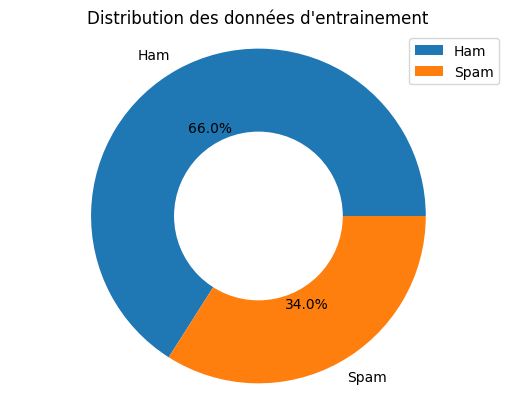

In [62]:
import matplotlib.pyplot as plt

# create some sample data
labels = ['Ham', 'Spam']
sizes = [Train_Y[Train_Y==0].shape[0], Train_Y[Train_Y==1].shape[0]]

# create a new figure and axis
fig, ax = plt.subplots()

# plot the pie chart
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

# set the aspect ratio to be equal
ax.axis('equal')

# draw a circle in the center of the chart
circle = plt.Circle((0, 0), 0.5, color='white')
ax.add_artist(circle)
ax.legend(labels, loc='upper right')
ax.set_title('Distribution des données d\'entrainement')
# display the plot
plt.show()

# MLP

In [63]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=1500, alpha=0.0001)

mlp.fit(Train_X,Train_Y)

mlp.score(Test_X,Test_Y)

0.9896825396825397

# SVM

In [64]:
from sklearn import svm


svmclassifier = svm.SVC(kernel='linear', C=1, gamma=1)

svmclassifier.fit(Train_X,Train_Y)

svmclassifier.score(Test_X,Test_Y)

1.0

# Regression Logistique

In [65]:
from sklearn.linear_model import LogisticRegression


logClassifier = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')

logClassifier.fit(Train_X,Train_Y)

logClassifier.score(Test_X,Test_Y)

1.0

# KNN

In [66]:
from sklearn.neighbors import KNeighborsClassifier


KnnClassifier = KNeighborsClassifier(n_neighbors=5)

KnnClassifier.fit(Train_X,Train_Y)

KnnClassifier.score(Test_X,Test_Y)

0.9492063492063492

# Naives bayes

In [67]:
from sklearn.naive_bayes import GaussianNB


NaiveBayesClassifier = GaussianNB()

NaiveBayesClassifier.fit(Train_X,Train_Y)

NaiveBayesClassifier.score(Test_X,Test_Y)


0.9952380952380953

# Keras (deeplearning)

In [89]:
import tensorflow as tf
from tensorflow import keras

# Define the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(3000,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Define the model
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(3000,)),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert the data to numpy arrays
X = np.array(Train_X)
y = np.array(Train_Y)

model.fit(X, y, epochs=10)

# Evaluate the model on test data
X_test = np.array(Test_X)
y_test = np.array(Test_Y)
test_loss, Keras_test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc) 

Epoch 1/10
92/92 [==============================] - 1s 3ms/step - loss: 0.3225 - accuracy: 0.9238
Epoch 2/10
92/92 [==============================] - 0s 3ms/step - loss: 0.1470 - accuracy: 0.9915
Epoch 3/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0945 - accuracy: 0.9969
Epoch 4/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0615 - accuracy: 0.9986
Epoch 5/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0410 - accuracy: 0.9997
Epoch 6/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 1.0000
Epoch 7/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0216 - accuracy: 1.0000
Epoch 8/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 1.0000
Epoch 9/10
92/92 [==============================] - 0s 3ms/step - loss: 0.0125 - accuracy: 1.0000
Epoch 10/10
92/92 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 1.0000
40/40 - 0s - loss: 

# Comparaison des résultat

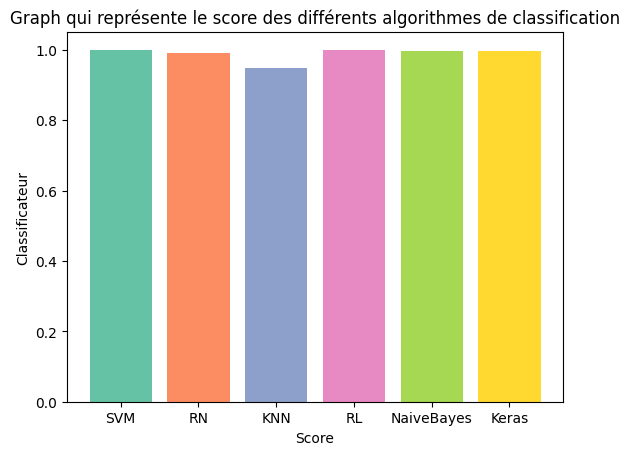

In [90]:
# Sample data
labels = ['SVM', 'RN', 'KNN', 'RL', 'NaiveBayes',"Keras"]
values = [svmclassifier.score(Test_X,Test_Y), mlp.score(Test_X,Test_Y), KnnClassifier.score(Test_X,Test_Y), logClassifier.score(Test_X,Test_Y), NaiveBayesClassifier.score(Test_X,Test_Y),Keras_test_acc]

# Create a new figure and axis
fig, ax = plt.subplots()
cmap = plt.cm.Set2
colors = cmap(range(len(labels)))

# Create a bar plot
ax.bar(labels, values,color = colors)

# Set the title and axis labels
ax.set_title('Graph qui représente le score des différents algorithmes de classification')
ax.set_xlabel('Score')
ax.set_ylabel('Classificateur')

# Display the plot
plt.show()

On remarque que la pluspart des classfieur donnes de bon résultat mais les meilleurs sont SVM et la regression logistique qui donne 100% de précision tant dis que KNN donne la moin bonne avec 94%

On  en déduit que notre préprocessing a été très significatif vu les resultat donnée avec une  moyenne de 99% de précision ce qui est plus que correcte et très encourageant pour l'utilisation de notre technique  
